# Cell Cycle Control in Yeast Fission

This notebook is in response [Observability of complex systems](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1215508110&file=pnas.201215508SI.pdf) Section SI.C

In [1]:
print(1)


1


In [2]:
print(1)

import os
import sys
print(1)
import numpy as np
import pandas as pd
print(1)

import matplotlib.pyplot as plt
import seaborn as sns
print(1)

import sympy as sp
from scipy.integrate import solve_ivp
print(1)


1
1
1
1
1


In [3]:
def jacobian_matrix_eval(jacobian, x):
    numerical_values = []
    for i, gene in enumerate(GENES):
        numerical_values.append((gene, x[i]))
    numerical_jacobian = jacobian.subs(numerical_values)
    return np.array(numerical_jacobian)
    
def buildNOMx(C, x, jacobian):
    O = C
    n = x.shape[0]
    fn = x
    fnp = jacobian_matrix_eval(jacobian, fn)
    O = np.vstack((O, C @ fnp))
    for i in range(n):
        fn = ode_system(fn)
        fnp_new = jacobian_matrix_eval(jacobian, fn)
        Onew = C @ fnp_new @ fnp
        O = np.vstack((O, Onew))
        fnp = fnp_new
    O = O.astype('float')
    O[np.isnan(O)] = 0
    return O

def omatsSVD(Omats, thresh=0.01):
    '''
    def omatsSVD(Omats, thresh=0.01)
    returns sigmas, mean_sigmas, components
    sigmas is the singular values
    mean_sigmas is the average singular value
    components is the number of singular values greater than the threshold
    '''
    sigmas = []
    components = []
    mean_sigmas = np.zeros((11,))
    for i in range(len(Omats)):
        O = Omats[i]
        O = O / O.sum(axis=1, keepdims=True)
        O[np.isnan(O)] = 0
        _, S, _ = np.linalg.svd(O, full_matrices=True)
        S /= sum(S)
        components.append(sum(S > thresh))
        sigmas.append(S)
        if mean_sigmas.shape == S.shape:
            mean_sigmas += S
        else:
            Stemp = []
            for ii in range(11):
                if ii < len(S):
                    Stemp.append(S[ii])
                else:
                    Stemp.append(0)
            mean_sigmas += Stemp
    mean_sigmas = (1/len(Omats)) * mean_sigmas
    return sigmas, mean_sigmas, components
    
def omats2scree(Omats, ax, thresh=0.01):
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=thresh)
    col = 'grey'
    lw = 0.5
    for i in range(len(sigmas)):
        ax.plot(np.arange(len(sigmas[i])), sigmas[i], color=col, linewidth=lw)

    ax.plot(np.arange(len(mean_sigmas)), mean_sigmas, color='k', linewidth=1)
    
    ax.axvline(x=np.mean(components), color='r', linestyle='--')

    mean_x = np.mean(components)
    ax.annotate(
        f'R={mean_x:.2f}',          # Text for annotation
        xy=(mean_x, 0.5),    # Position to annotate (x, y)
        xytext=(mean_x + 0.1, 0.55),  # Text position (slightly offset for visibility)
        # arrowprops=dict(facecolor='black', shrink=0.05),  # Optional arrow from text to point
        fontsize=12          # Increase text size if needed
    )
    return ax

def get_key(gene_list):
    key = gene_list[0]
    for i, g in enumerate(gene_list):
        if i == 0:
            continue
        key += (' & ' + g)
    return key        

# Define System and Parameters

In [4]:
GENES = ['Cdc25', 'G1K', 'G1R', 'G2K', 'G2R', 'IE', 'mass', 'PG2', 'PG2R', 'R', 'UbE', 'UbE2', 'Wee1']

K1 = 0.015
K3 = 0.09375
K2 = 0.05
K4 = 0.1875
K5 = 0.00175
K7 = 100
K7R = 0.1
K6 = 0
K8 = 10
K8R = 0.1
KP = 3.25
KI = 0.4
KIR = 0.1
KUR = 0.1
KU = 0.2
KUR2 = 0.3
KU2 = 1
KWR = 0.25
KW = 1
KCR = 0.25
KC = 1
V2 = 0.25
V2P = 0.0075 # V2'
V25 = 0.5
V25P = 0.025 # V25'
V6 = 7.5
V6P = 0.0375 # V6P
VW = 0.35
VWP = 0.035 # VW'
KMC = KMCR = 0.1
KMI = KMIR = 0.01
KMP = 0.001
KMU = KMUR = 0.01
KMU2 = KMUR2 = 0.05
KMW = KMWR = 0.1
ALPHA = 0.25
BETA = 0.05
MU = 0.00495
CIG1 = 0

K6P = 0 # Not defined in the paper
KK = 0
K2P = 0
IEC = 0

In [11]:
def ode_system(y):
    # Unpack variables from y (the state vector)
    Cdc25, G1K, G1R, G2K, G2R, IE, mass, PG2, PG2R, R, UbE, UbE2, Wee1 = y

    # ODE system (same as what you provided)
    dCdc25 = -1 * (KCR * Cdc25 / (KMCR + Cdc25)) + (KC * Cdc25 * (G2K + BETA * PG2) / (KMC + 1 - Cdc25))
    dG1K   = K5 + ((K4 + K8R) * G1R) - K8 * G1K * R - (G1K * (V6P * (1 - UbE2) + (V6 * UbE2)))
    dG1R   = - K4 * G1R - K6P * G1R - K8R * G1R + K8 * G1K * R
    dG2K   = K1 + (K4 + K7R) * G2R + (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 - KK * G2K * R - G2K * (V2P * (1 - UbE) + V2 * UbE) - G2K * (VWP * (1 - Wee1) + VW * Wee1)
    dG2R   =  -K4 * G2R - K7R * G2R + K7 * G2K * R - G2R * (K2P + V2P * (1 - UbE) + V2 * UbE)
    dIE    = (- KIR * IE / (KMIR + IE)) + ((KI * IEC * (G2K + BETA * PG2)) / (KMI + IEC))
    dmass  = MU * mass
    dPG2   = -1 * (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 + K4 * PG2R + K7R * PG2R - K7 * PG2 * R - PG2 * (V2P *( 1- UbE) + V2 * UbE) + G2K * (VWP * (1 - Wee1) + VW * Wee1)
    dPG2R  = - K4 * PG2R - K7R * PG2R + K7 * PG2 * R - PG2R * (K2P + V2P * ( 1 - UbE) + V2 * UbE)
    dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)
    dUbE   = -1 * ((KUR * UbE)/(KMUR + UbE)) + ((KU * IE * (1 - UbE))/(KMU + 1 - UbE))
    dUbE2  = -1 * ((KUR2*UbE2) / (KMUR2 + UbE2)) + ((KU2 * (G2K + BETA * PG2) * (1 - UbE2))/ (KMU2 + 1 - UbE2))
    dWee1  = -1 * ((KW * (G2K + BETA * PG2) + Wee1)/(KWR + Wee1)) + ((KWR * (1 - Wee1))/(KMWR + 1 - Wee1))
    
    return [dCdc25, dG1K, dG1R, dG2K, dG2R, dIE, dmass, dPG2, dPG2R, dR, dUbE, dUbE2, dWee1]

In [12]:
# Define the variables
Cdc25, G1K, G1R, G2K, G2R, IE, mass, PG2, PG2R, R, UbE, UbE2, Wee1 = sp.symbols('Cdc25 G1K G1R G2K G2R IE mass PG2 PG2R R UbE UbE2 Wee1')

# ODE system (same as what you provided)
dCdc25 = -1 * (KCR * Cdc25 / (KMCR + Cdc25)) + (KC * Cdc25 * (G2K + BETA * PG2) / (KMC + 1 - Cdc25))
dG1K   = K5 + ((K4 + K8R) * G1R) - K8 * G1K * R - (G1K * (V6P * (1 - UbE2) + (V6 * UbE2)))
dG1R   = - K4 * G1R - K6P * G1R - K8R * G1R + K8 * G1K * R
dG2K   = K1 + (K4 + K7R) * G2R + (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 - KK * G2K * R - G2K * (V2P * (1 - UbE) + V2 * UbE) - G2K * (VWP * (1 - Wee1) + VW * Wee1)
dG2R   =  -K4 * G2R - K7R * G2R + K7 * G2K * R - G2R * (K2P + V2P * (1 - UbE) + V2 * UbE)
dIE    = (- KIR * IE / (KMIR + IE)) + ((KI * IEC * (G2K + BETA * PG2)) / (KMI + IEC))
dmass  = MU * mass
dPG2   = -1 * (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 + K4 * PG2R + K7R * PG2R - K7 * PG2 * R - PG2 * (V2P *( 1- UbE) + V2 * UbE) + G2K * (VWP * (1 - Wee1) + VW * Wee1)
dPG2R  = - K4 * PG2R - K7R * PG2R + K7 * PG2 * R - PG2R * (K2P + V2P * ( 1 - UbE) + V2 * UbE)
dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)
dUbE   = -1 * ((KUR * UbE)/(KMUR + UbE)) + ((KU * IE * (1 - UbE))/(KMU + 1 - UbE))
dUbE2  = -1 * ((KUR2*UbE2) / (KMUR2 + UbE2)) + ((KU2 * (G2K + BETA * PG2) * (1 - UbE2))/ (KMU2 + 1 - UbE2))
dWee1  = -1 * ((KW * (G2K + BETA * PG2) + Wee1)/(KWR + Wee1)) + ((KWR * (1 - Wee1))/(KMWR + 1 - Wee1))

In [13]:
# System of ODEs
odes = [dCdc25, dG1K, dG1R, dG2K, dG2R, dIE, dmass, dPG2, dPG2R, dR, dUbE, dUbE2, dWee1]

# Variables
vars = [Cdc25, G1K, G1R, G2K, G2R, IE, mass, PG2, PG2R, R, UbE, UbE2, Wee1]

# Compute the Jacobian matrix
jacobian_matrix = sp.Matrix(odes).jacobian(vars)
jacobian_matrix

Matrix([
[0.25*Cdc25/(Cdc25 + 0.1)**2 + 0.826446280991735*Cdc25*(G2K + 0.05*PG2)/(1 - 0.909090909090909*Cdc25)**2 - 0.25/(Cdc25 + 0.1) + (G2K + 0.05*PG2)/(1.1 - Cdc25),                               0,       0,               Cdc25/(1.1 - Cdc25),                   0,                                       0,                                               0,                   0.05*Cdc25/(1.1 - Cdc25),                   0,                                                                                                                           0,                                                                                                                               0,                                                                                                                                                             0,                                                                                                                                                     0],
[            

In [14]:
def ode_system_v2(t, y):
    # Unpack variables from y (the state vector)
    Cdc25, G1K, G1R, G2K, G2R, IE, mass, PG2, PG2R, R, UbE, UbE2, Wee1 = y

    # ODE system (same as what you provided)
    dCdc25 = -1 * (KCR * Cdc25 / (KMCR + Cdc25)) + (KC * Cdc25 * (G2K + BETA * PG2) / (KMC + 1 - Cdc25))
    dG1K   = K5 + ((K4 + K8R) * G1R) - K8 * G1K * R - (G1K * (V6P * (1 - UbE2) + (V6 * UbE2)))
    dG1R   = - K4 * G1R - K6P * G1R - K8R * G1R + K8 * G1K * R
    dG2K   = K1 + (K4 + K7R) * G2R + (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 - KK * G2K * R - G2K * (V2P * (1 - UbE) + V2 * UbE) - G2K * (VWP * (1 - Wee1) + VW * Wee1)
    dG2R   =  -K4 * G2R - K7R * G2R + K7 * G2K * R - G2R * (K2P + V2P * (1 - UbE) + V2 * UbE)
    dIE    = (- KIR * IE / (KMIR + IE)) + ((KI * IEC * (G2K + BETA * PG2)) / (KMI + IEC))
    dmass  = MU * mass
    dPG2   = -1 * (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 + K4 * PG2R + K7R * PG2R - K7 * PG2 * R - PG2 * (V2P *( 1- UbE) + V2 * UbE) + G2K * (VWP * (1 - Wee1) + VW * Wee1)
    dPG2R  = - K4 * PG2R - K7R * PG2R + K7 * PG2 * R - PG2R * (K2P + V2P * ( 1 - UbE) + V2 * UbE)
    dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)
    dUbE   = -1 * ((KUR * UbE)/(KMUR + UbE)) + ((KU * IE * (1 - UbE))/(KMU + 1 - UbE))
    dUbE2  = -1 * ((KUR2*UbE2) / (KMUR2 + UbE2)) + ((KU2 * (G2K + BETA * PG2) * (1 - UbE2))/ (KMU2 + 1 - UbE2))
    dWee1  = -1 * ((KW * (G2K + BETA * PG2) + Wee1)/(KWR + Wee1)) + ((KWR * (1 - Wee1))/(KMWR + 1 - Wee1))
    
    return [dCdc25, dG1K, dG1R, dG2K, dG2R, dIE, dmass, dPG2, dPG2R, dR, dUbE, dUbE2, dWee1]
    
# Initial conditions for each variable (adjust these as appropriate for your system)
initial_conditions = [1.0] * 13  # Placeholder values, replace with actual initial conditions

# Time span for the simulation
t_span = (0, 50)  # Start and end times
t_eval = np.linspace(*t_span, 500)  # Time points where solution is computed

# Solve the ODE system
solution = solve_ivp(ode_system_v2, t_span, initial_conditions, t_eval=t_eval) # , method='RK45')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each variable in the solution
for i in range(len(initial_conditions)):
    ax.plot(solution.t, solution.y[i], label=f'Variable {i+1}')

# Customize plot
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('ODE System Simulation')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [15]:
len(t_eval)

500

# Sample Different Random Initial Conditions

In [16]:
# dictionary to save the NOMs. keys indicate which variables were observed
NOM_dict = {}
for k in GENES:
    NOM_dict[k] = []
NOM_dict['all'] = []

# measure all
C = np.eye(len(GENES))

# random initial conditions
ITR = 1000
for itr in range(ITR):
    x = np.random.rand(len(GENES),)
    NOM = buildNOMx(C, x, jacobian_matrix)
    NOM_dict['all'].append(NOM)
    if itr % 25 == 0:
        print(f"{itr} / {ITR}")

# separate out observability matrices by gene
for i, gene in enumerate(GENES):
    for NOM in NOM_dict['all']:
        O = NOM[i::13]
        NOM_dict[gene].append(O)
        

/tmp/ipykernel_1339644/2462461890.py:7: RuntimeWarning: overflow encountered in scalar multiply
  dG1K   = K5 + ((K4 + K8R) * G1R) - K8 * G1K * R - (G1K * (V6P * (1 - UbE2) + (V6 * UbE2)))
/tmp/ipykernel_1339644/2462461890.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dG1R   = - K4 * G1R - K6P * G1R - K8R * G1R + K8 * G1K * R
/tmp/ipykernel_1339644/2462461890.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dPG2   = -1 * (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 + K4 * PG2R + K7R * PG2R - K7 * PG2 * R - PG2 * (V2P *( 1- UbE) + V2 * UbE) + G2K * (VWP * (1 - Wee1) + VW * Wee1)
/tmp/ipykernel_1339644/2462461890.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dPG2R  = - K4 * PG2R - K7R * PG2R + K7 * PG2 * R - PG2R * (K2P + V2P * ( 1 - UbE) + V2 * UbE)
/tmp/ipykernel_1339644/2462461890.py:15: RuntimeWarning: overflow encountered in scalar multiply
  dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G

0 / 1000


/tmp/ipykernel_1339644/2462461890.py:10: RuntimeWarning: overflow encountered in scalar multiply
  dG2R   =  -K4 * G2R - K7R * G2R + K7 * G2K * R - G2R * (K2P + V2P * (1 - UbE) + V2 * UbE)
/tmp/ipykernel_1339644/2462461890.py:6: RuntimeWarning: overflow encountered in scalar multiply
  dCdc25 = -1 * (KCR * Cdc25 / (KMCR + Cdc25)) + (KC * Cdc25 * (G2K + BETA * PG2) / (KMC + 1 - Cdc25))
/tmp/ipykernel_1339644/2462461890.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dPG2   = -1 * (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 + K4 * PG2R + K7R * PG2R - K7 * PG2 * R - PG2 * (V2P *( 1- UbE) + V2 * UbE) + G2K * (VWP * (1 - Wee1) + VW * Wee1)
/tmp/ipykernel_1339644/2462461890.py:17: RuntimeWarning: overflow encountered in scalar multiply
  dUbE2  = -1 * ((KUR2*UbE2) / (KMUR2 + UbE2)) + ((KU2 * (G2K + BETA * PG2) * (1 - UbE2))/ (KMU2 + 1 - UbE2))
/tmp/ipykernel_1339644/2462461890.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  dG2K   = K1 + (K4 + K7R) * G

25 / 1000
50 / 1000
75 / 1000
100 / 1000
125 / 1000
150 / 1000
175 / 1000
200 / 1000


/tmp/ipykernel_1339644/2462461890.py:14: RuntimeWarning: invalid value encountered in scalar add
  dPG2R  = - K4 * PG2R - K7R * PG2R + K7 * PG2 * R - PG2R * (K2P + V2P * ( 1 - UbE) + V2 * UbE)
/tmp/ipykernel_1339644/2462461890.py:15: RuntimeWarning: invalid value encountered in scalar divide
  dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)


225 / 1000
250 / 1000
275 / 1000


/tmp/ipykernel_1339644/2462461890.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  dG2K   = K1 + (K4 + K7R) * G2R + (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 - KK * G2K * R - G2K * (V2P * (1 - UbE) + V2 * UbE) - G2K * (VWP * (1 - Wee1) + VW * Wee1)
/tmp/ipykernel_1339644/2462461890.py:15: RuntimeWarning: invalid value encountered in scalar add
  dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)


300 / 1000
325 / 1000
350 / 1000
375 / 1000
400 / 1000
425 / 1000
450 / 1000
475 / 1000
500 / 1000
525 / 1000
550 / 1000
575 / 1000
600 / 1000
625 / 1000
650 / 1000
675 / 1000
700 / 1000
725 / 1000
750 / 1000
775 / 1000
800 / 1000
825 / 1000
850 / 1000
875 / 1000
900 / 1000
925 / 1000
950 / 1000
975 / 1000


In [17]:
import pickle

# Specify the filename and path
filename = 'data/DNA_replication_control_12_10_2024.pkl'

# Save NOM_dict to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(NOM_dict, file)


In [18]:
NOM_dict.keys()

dict_keys(['Cdc25', 'G1K', 'G1R', 'G2K', 'G2R', 'IE', 'mass', 'PG2', 'PG2R', 'R', 'UbE', 'UbE2', 'Wee1', 'all'])

In [ ]:
import pickle

# Specify the filename and path
filename = 'data/DNA_replication_control_12_10_2024.pkl'

# Load the pickle file
with open(filename, 'rb') as file:
    NOM_dict = pickle.load(file)

# Print the dictionary to check if it's loaded correctly
print(NOM_dict.keys())


## Individual Sensor Utility

/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)
/home/jpic/.local/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/jpic/.local/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


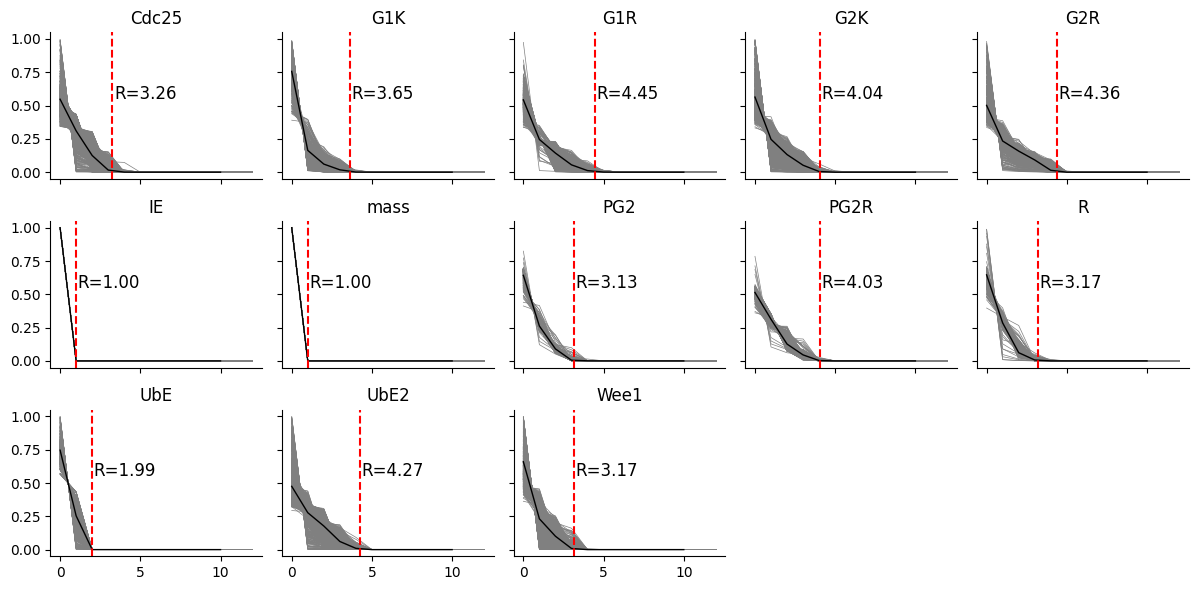

In [19]:
fig, axs = plt.subplots(3,5, figsize=(12,6), sharex=True, sharey=True)
for i, gene in enumerate(GENES):
    omats2scree(NOM_dict[gene], axs[i // 5, i % 5])
    axs[i // 5, i % 5].set_title(gene)
sns.despine()
axs[2,4].axis('off')
axs[2,3].axis('off')
plt.tight_layout()
plt.savefig('CC-effective-ranks-12_10_2024.png')
plt.show()

## Pairs of Sensors

In [20]:
for i, gene1 in enumerate(GENES):
    for j, gene2 in enumerate(GENES):
        if j <= i:
            continue
        newKey = get_key([gene1, gene2])
        Omats = []
        for k in range(len(NOM_dict[gene1])):
            Omats.append(np.vstack((NOM_dict[gene1][k], NOM_dict[gene2][k])))
        NOM_dict[newKey] = Omats
NOM_dict.keys()

dict_keys(['Cdc25', 'G1K', 'G1R', 'G2K', 'G2R', 'IE', 'mass', 'PG2', 'PG2R', 'R', 'UbE', 'UbE2', 'Wee1', 'all', 'Cdc25 & G1K', 'Cdc25 & G1R', 'Cdc25 & G2K', 'Cdc25 & G2R', 'Cdc25 & IE', 'Cdc25 & mass', 'Cdc25 & PG2', 'Cdc25 & PG2R', 'Cdc25 & R', 'Cdc25 & UbE', 'Cdc25 & UbE2', 'Cdc25 & Wee1', 'G1K & G1R', 'G1K & G2K', 'G1K & G2R', 'G1K & IE', 'G1K & mass', 'G1K & PG2', 'G1K & PG2R', 'G1K & R', 'G1K & UbE', 'G1K & UbE2', 'G1K & Wee1', 'G1R & G2K', 'G1R & G2R', 'G1R & IE', 'G1R & mass', 'G1R & PG2', 'G1R & PG2R', 'G1R & R', 'G1R & UbE', 'G1R & UbE2', 'G1R & Wee1', 'G2K & G2R', 'G2K & IE', 'G2K & mass', 'G2K & PG2', 'G2K & PG2R', 'G2K & R', 'G2K & UbE', 'G2K & UbE2', 'G2K & Wee1', 'G2R & IE', 'G2R & mass', 'G2R & PG2', 'G2R & PG2R', 'G2R & R', 'G2R & UbE', 'G2R & UbE2', 'G2R & Wee1', 'IE & mass', 'IE & PG2', 'IE & PG2R', 'IE & R', 'IE & UbE', 'IE & UbE2', 'IE & Wee1', 'mass & PG2', 'mass & PG2R', 'mass & R', 'mass & UbE', 'mass & UbE2', 'mass & Wee1', 'PG2 & PG2R', 'PG2 & R', 'PG2 & UbE', 

In [21]:
A = np.zeros((len(GENES), len(GENES)))
for i, gene1 in enumerate(GENES):
    for j, gene2 in enumerate(GENES):
        if j <= i:
            continue
        newKey = get_key([gene1, gene2])
        Omats = NOM_dict[newKey]
        sigmas, mean_sigmas, components = omatsSVD(Omats)
        A[i,j] = np.mean(components)
A = A + A.T

/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)


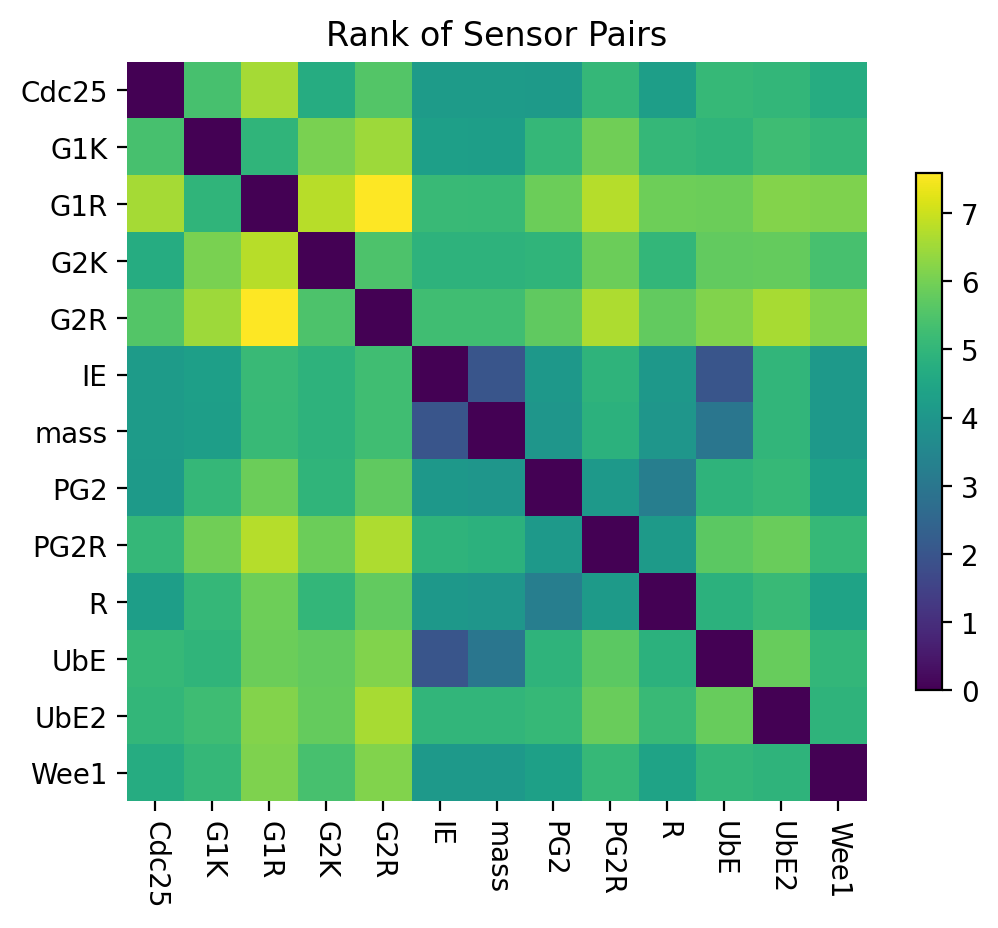

In [24]:
plt.figure(dpi=200)
plt.imshow(A)
plt.yticks(ticks=range(len(GENES)), labels=GENES)  # Set x-axis tick labels
plt.xticks(ticks=range(len(GENES)), labels=GENES, rotation=-90)  # Set y-axis tick labels

cb = plt.colorbar(shrink=0.7)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title('Rank of Sensor Pairs')
plt.savefig('CC-effective-rank-pairs.png')
plt.show()

In [26]:
A[2,4]

7.592

## Greedy Selection to Fully Observable

### Visualize Greedy Selection

In [59]:
ranks = []
biomarkers = ['G1R', 'G2R', 'PG2R', 'UbE', 'mass']
for i in tqdm(range(len(biomarkers))):
    if i != 0:
        key = key + ' & ' + biomarkers[i]
    else:
        key = biomarkers[i]
    print(key)

    Omats = NOM_dict[key]
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=0.00001)
    ranks.append(np.mean(components))

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)
 40%|████      | 2/5 [00:00<00:00, 12.97it/s]

G1R
G1R & G2R
G1R & G2R & PG2R


 80%|████████  | 4/5 [00:00<00:00, 10.00it/s]

G1R & G2R & PG2R & UbE
G1R & G2R & PG2R & UbE & mass


100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


In [60]:
ranks

[5.964, 10.19, 11.999, 12.998, 13.0]

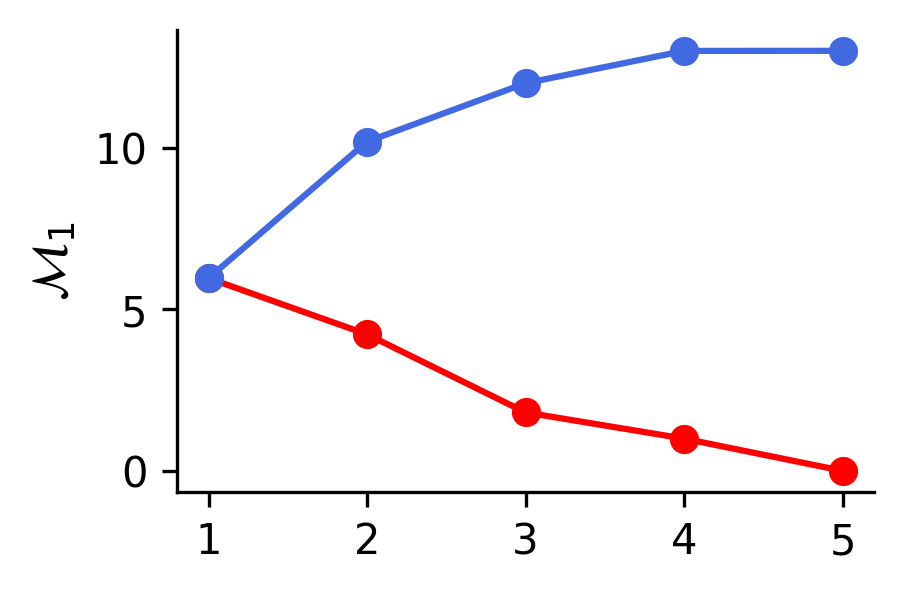

In [84]:
plt.figure(dpi=300, figsize=(3, 2))
new_utility = [ranks[0]] + [ranks[i] - ranks[i-1] for i in range(1, len(ranks))]
plt.plot(np.arange(len(ranks)) + 1, new_utility, marker='o', linestyle='-', color='red')
plt.plot(np.arange(len(ranks)) + 1, ranks, marker='o', linestyle='-', color='royalblue')
# plt.xlabel('Number of Sensors', fontsize=12)
plt.ylabel(r'$\mathcal{M}_1$', fontsize=12)
plt.xticks([1,2,3,4,5])
sns.despine()
plt.show()

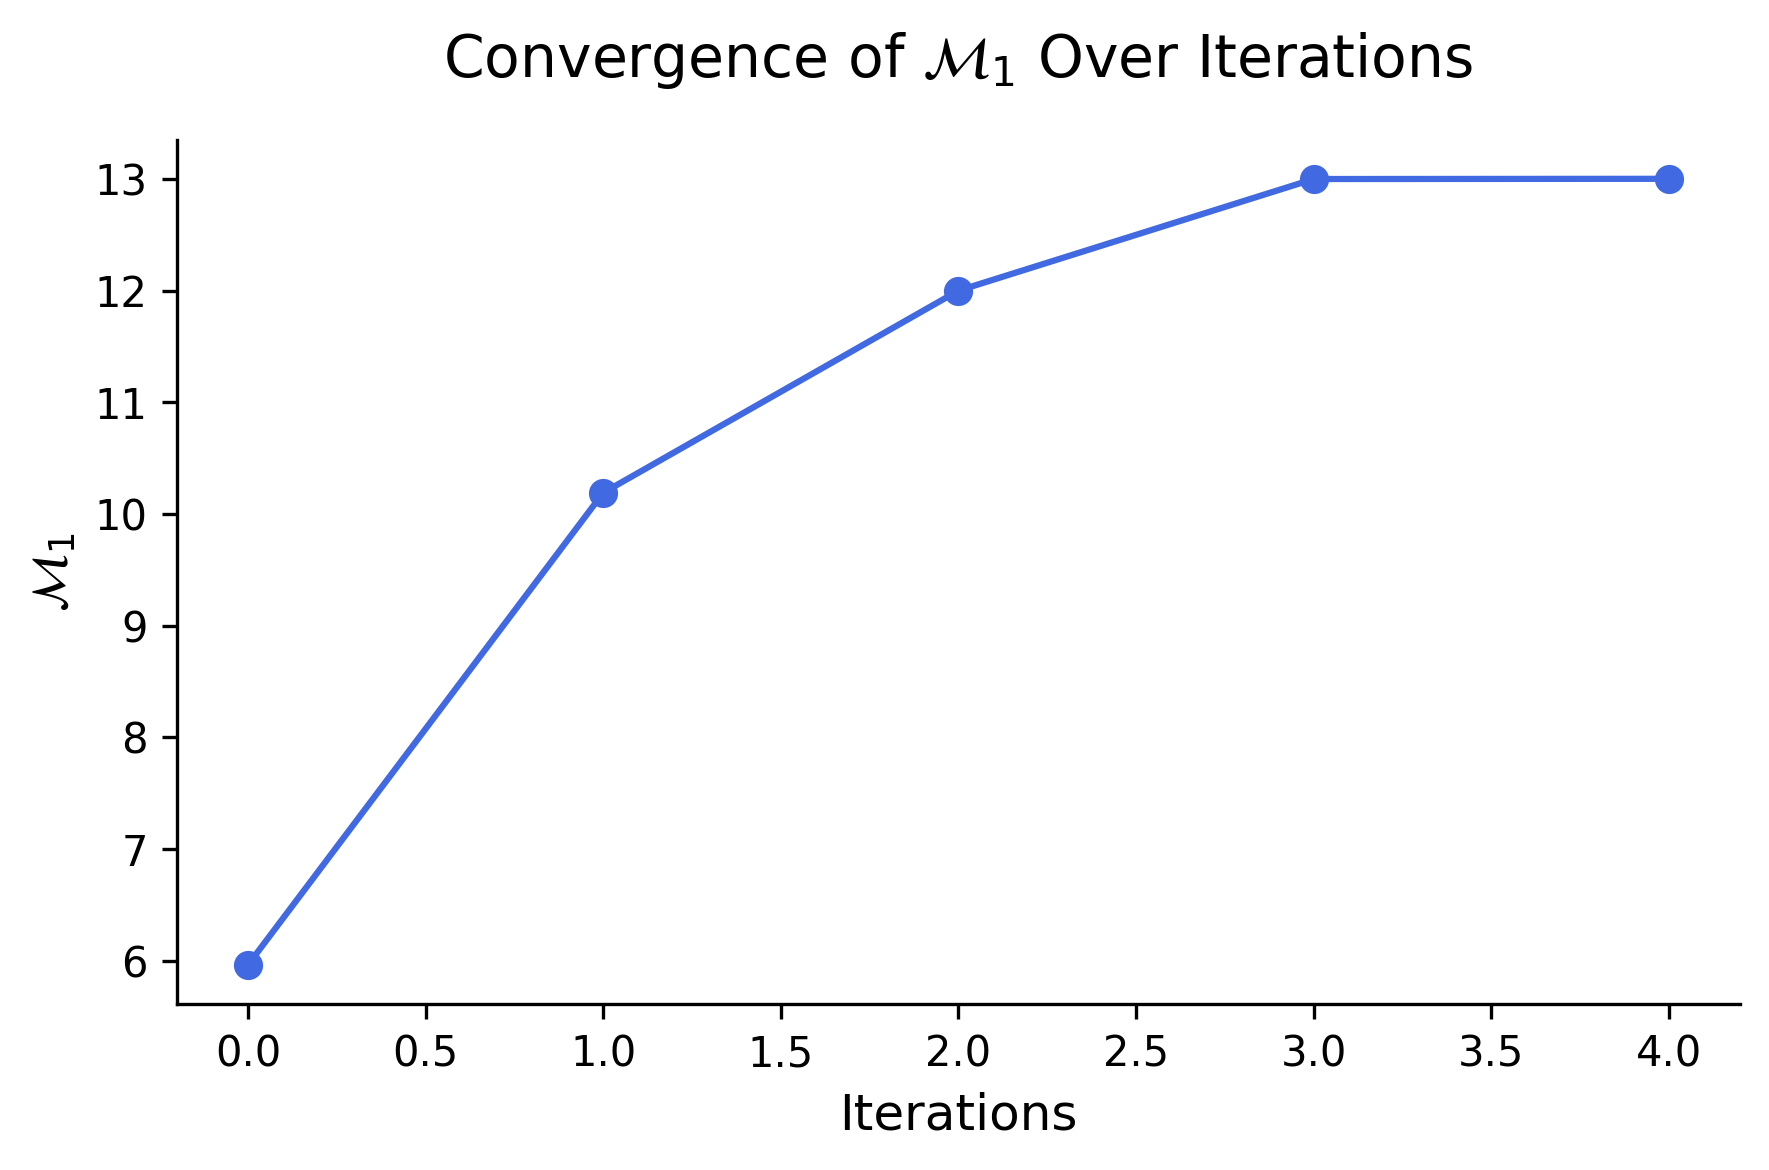

In [64]:
# Create the figure and axis
sns.reset_orig()
plt.figure(dpi=300, figsize=(6, 4))

# Plot the data
plt.plot(ranks, marker='o', linestyle='-', color='royalblue') # , label=r'$\mathcal{M}_1$')

# Customize the axes
plt.xlabel('Iterations', fontsize=12)
plt.ylabel(r'$\mathcal{M}_1$', fontsize=12)
plt.title(r'Convergence of $\mathcal{M}_1$ Over Iterations', fontsize=14, pad=15)

# Adjust tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove spines
sns.despine()

# Save and display the plot
plt.tight_layout()
plt.show()


In [67]:
ranks

[5.964, 10.19, 11.999, 12.998, 13.0]

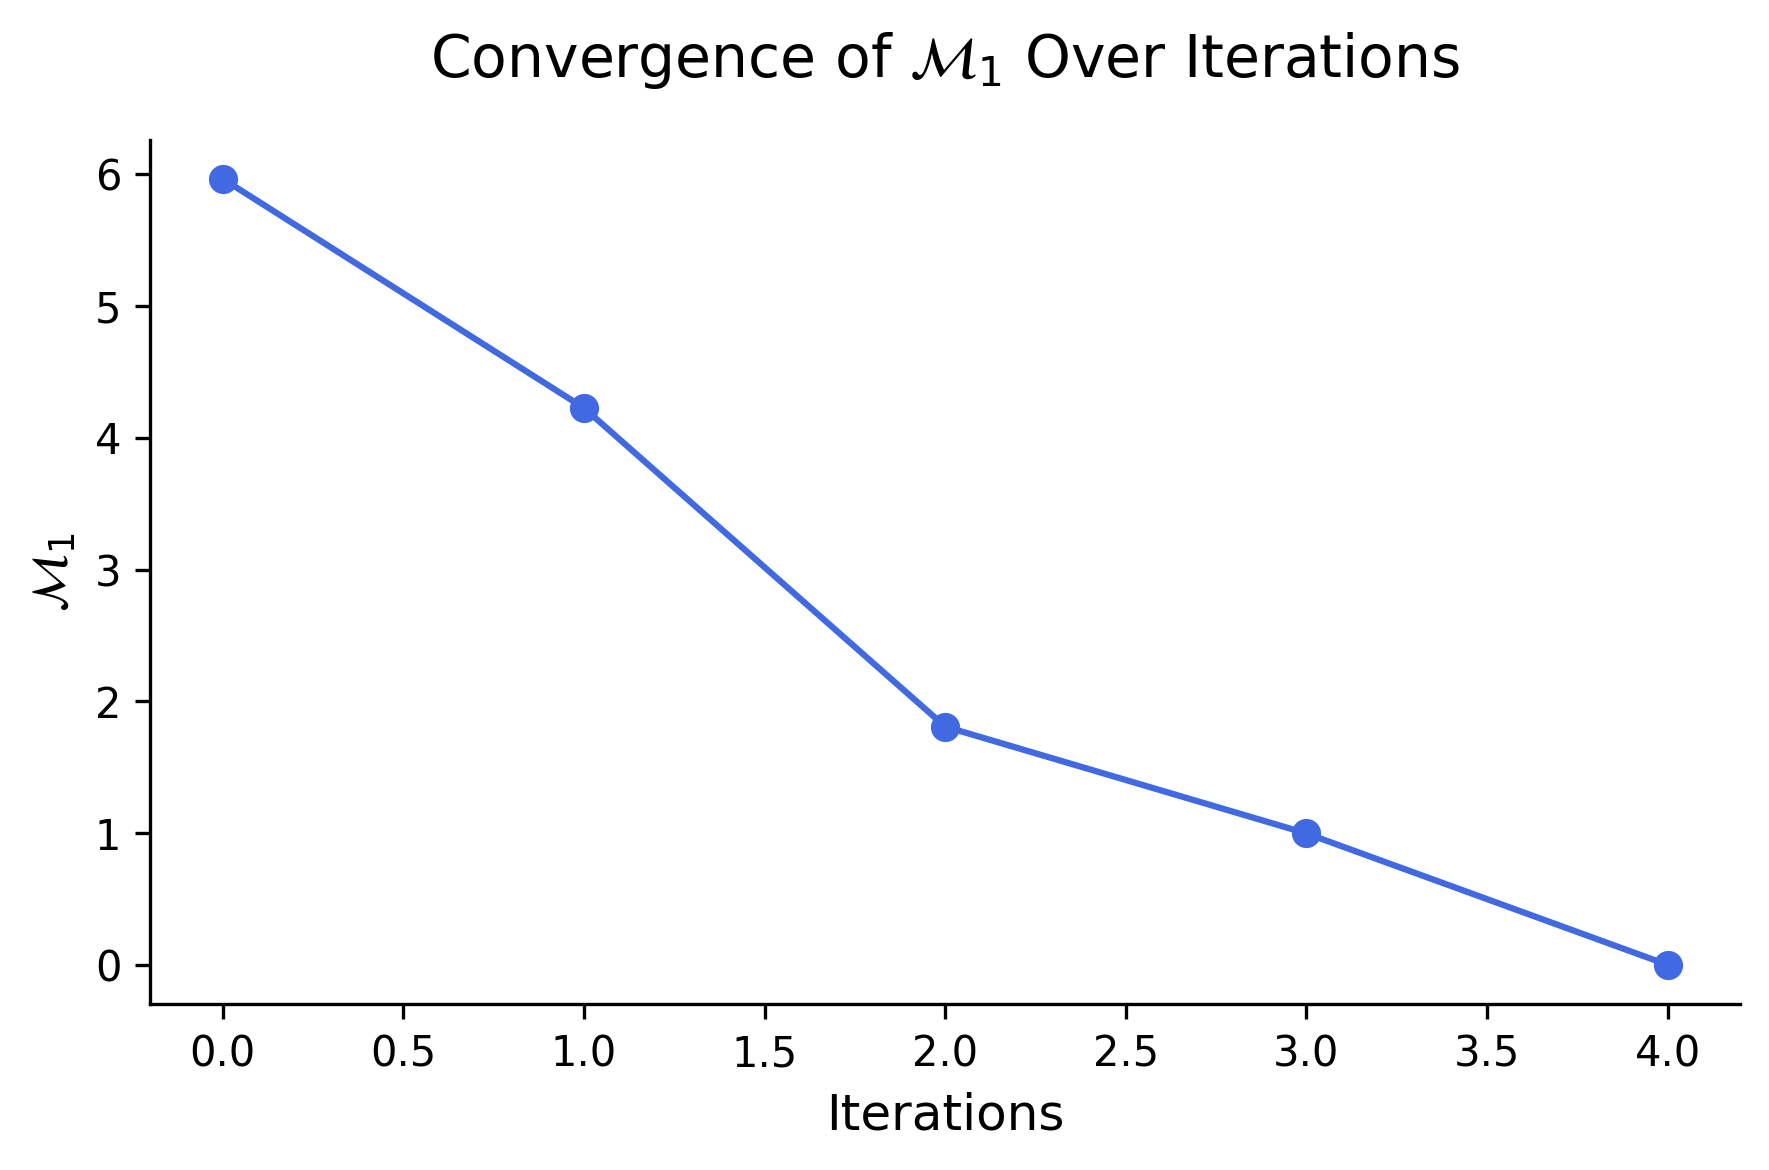

In [68]:
new_utility = [ranks[0]] + [ranks[i] - ranks[i-1] for i in range(1, len(ranks))]

# Create the figure and axis
sns.reset_orig()
plt.figure(dpi=300, figsize=(6, 4))
# Plot the data
plt.plot(new_utility, marker='o', linestyle='-', color='royalblue') # , label=r'$\mathcal{M}_1$')

# Customize the axes
plt.xlabel('Iterations', fontsize=12)
plt.ylabel(r'$\mathcal{M}_1$', fontsize=12)
plt.title(r'Convergence of $\mathcal{M}_1$ Over Iterations', fontsize=14, pad=15)

# Adjust tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove spines
sns.despine()

# Save and display the plot
plt.tight_layout()
plt.show()


### Execute Greedy Steps

In [27]:
newKey

'UbE2 & Wee1'

In [32]:
from tqdm import tqdm

In [33]:
biomarkers = ['G1R', 'G2R']
key = 'G1R & G2R'
effectiveRanks = {}
for gene in tqdm(GENES):
    if gene in biomarkers:
        continue
    newKey = get_key([key, gene])
    Omats = []
    for k in range(len(NOM_dict[gene])):
        Omats.append(np.vstack((NOM_dict[key][k], NOM_dict[gene][k])))
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=0.00001)
    NOM_dict[newKey] = Omats
    effectiveRanks[newKey] = np.mean(components)
for k, v in effectiveRanks.items():
    print(f"{k}   \t{v}")

  0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)
 46%|████▌     | 6/13 [00:00<00:00, 15.29it/s]/home/jpic/.local/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
100%|██████████| 13/13 [00:01<00:00, 10.66it/s]

G1R & G2R & Cdc25   	11.375
G1R & G2R & G1K   	10.468
G1R & G2R & G2K   	11.714
G1R & G2R & IE   	11.135
G1R & G2R & mass   	10.75
G1R & G2R & PG2   	11.996
G1R & G2R & PG2R   	11.999
G1R & G2R & R   	11.963
G1R & G2R & UbE   	11.922
G1R & G2R & UbE2   	11.917
G1R & G2R & Wee1   	11.794


In [34]:
biomarkers = ['G1R', 'G2R', 'PG2R']
key = 'G1R & G2R & PG2R'
effectiveRanks = {}
for gene in tqdm(GENES):
    if gene in biomarkers:
        continue
    newKey = get_key([key, gene])
    Omats = []
    for k in range(len(NOM_dict[gene])):
        Omats.append(np.vstack((NOM_dict[key][k], NOM_dict[gene][k])))
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=0.00001)
    NOM_dict[newKey] = Omats
    effectiveRanks[newKey] = np.mean(components)
for k, v in effectiveRanks.items():
    print(f"{k}   \t{v}")

  0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)
100%|██████████| 13/13 [00:01<00:00,  9.99it/s]

G1R & G2R & PG2R & Cdc25   	11.998
G1R & G2R & PG2R & G1K   	11.999
G1R & G2R & PG2R & G2K   	12.691
G1R & G2R & PG2R & IE   	12.999
G1R & G2R & PG2R & mass   	11.999
G1R & G2R & PG2R & PG2   	11.999
G1R & G2R & PG2R & R   	11.999
G1R & G2R & PG2R & UbE   	12.998
G1R & G2R & PG2R & UbE2   	11.995
G1R & G2R & PG2R & Wee1   	12.005


In [35]:
biomarkers = ['G1R', 'G2R', 'PG2R', 'UbE']
key = 'G1R & G2R & PG2R & UbE'
effectiveRanks = {}
for gene in tqdm(GENES):
    if gene in biomarkers:
        continue
    newKey = get_key([key, gene])
    Omats = []
    for k in range(len(NOM_dict[gene])):
        Omats.append(np.vstack((NOM_dict[key][k], NOM_dict[gene][k])))
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=0.00001)
    NOM_dict[newKey] = Omats
    effectiveRanks[newKey] = np.mean(components)
for k, v in effectiveRanks.items():
    print(f"{k}   \t{v}")

  0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)
100%|██████████| 13/13 [00:01<00:00,  9.58it/s]

G1R & G2R & PG2R & UbE & Cdc25   	12.997
G1R & G2R & PG2R & UbE & G1K   	12.998
G1R & G2R & PG2R & UbE & G2K   	12.998
G1R & G2R & PG2R & UbE & IE   	12.998
G1R & G2R & PG2R & UbE & mass   	13.0
G1R & G2R & PG2R & UbE & PG2   	12.998
G1R & G2R & PG2R & UbE & R   	12.999
G1R & G2R & PG2R & UbE & UbE2   	12.997
G1R & G2R & PG2R & UbE & Wee1   	12.997


These are the greedyly selected biomarkers required to make the system observable.
    
```biomarkers = ['G1R', 'G2R', 'PG2R', 'UbE', 'mass']```


### Scree Plots of Greedy Sensors

In [10]:
biomarkers = ['G1R', 'G2R', 'PG2R', 'UbE']

# measure all
C = np.zeros((4, len(GENES)))
for i in range(4):
    C[i, GENES.index(biomarkers[i])] = 1
print(C)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [28]:
# dictionary to save the NOMs. keys indicate which variables were observed
# NOM_dict = {}
# for k in GENES:
#     NOM_dict[k] = []
# NOM_dict['biomarkers'] = []

# random initial conditions
ITR = 1000
for itr in range(ITR):
    x = np.random.rand(len(GENES),)
    NOM = buildNOMx(C, x, jacobian_matrix)
    NOM_dict['biomarkers'].append(NOM)
    if itr % 25 == 0:
        print(f"{itr} / {ITR}")
        

/tmp/ipykernel_578294/2462461890.py:6: RuntimeWarning: overflow encountered in scalar multiply
  dCdc25 = -1 * (KCR * Cdc25 / (KMCR + Cdc25)) + (KC * Cdc25 * (G2K + BETA * PG2) / (KMC + 1 - Cdc25))
/tmp/ipykernel_578294/2462461890.py:7: RuntimeWarning: overflow encountered in scalar multiply
  dG1K   = K5 + ((K4 + K8R) * G1R) - K8 * G1K * R - (G1K * (V6P * (1 - UbE2) + (V6 * UbE2)))
/tmp/ipykernel_578294/2462461890.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dG1R   = - K4 * G1R - K6P * G1R - K8R * G1R + K8 * G1K * R
/tmp/ipykernel_578294/2462461890.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dG2K   = K1 + (K4 + K7R) * G2R + (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 - KK * G2K * R - G2K * (V2P * (1 - UbE) + V2 * UbE) - G2K * (VWP * (1 - Wee1) + VW * Wee1)
/tmp/ipykernel_578294/2462461890.py:10: RuntimeWarning: overflow encountered in scalar multiply
  dG2R   =  -K4 * G2R - K7R * G2R + K7 * G2K * R - G2R * (K2P + V2P * (1 - UbE) + V2 * UbE)
/tmp/ipy

0 / 1000


/tmp/ipykernel_578294/2462461890.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  dIE    = (- KIR * IE / (KMIR + IE)) + ((KI * IEC * (G2K + BETA * PG2)) / (KMI + IEC))
/tmp/ipykernel_578294/2462461890.py:18: RuntimeWarning: invalid value encountered in scalar divide
  dWee1  = -1 * ((KW * (G2K + BETA * PG2) + Wee1)/(KWR + Wee1)) + ((KWR * (1 - Wee1))/(KMWR + 1 - Wee1))
/tmp/ipykernel_578294/2462461890.py:14: RuntimeWarning: invalid value encountered in scalar add
  dPG2R  = - K4 * PG2R - K7R * PG2R + K7 * PG2 * R - PG2R * (K2P + V2P * ( 1 - UbE) + V2 * UbE)
/tmp/ipykernel_578294/2462461890.py:15: RuntimeWarning: invalid value encountered in scalar divide
  dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)


25 / 1000
50 / 1000


/tmp/ipykernel_578294/2257163869.py:20: RuntimeWarning: overflow encountered in matmul
  Onew = C @ fnp_new @ fnp


75 / 1000
100 / 1000


/tmp/ipykernel_578294/2462461890.py:15: RuntimeWarning: invalid value encountered in scalar add
  dR     = K3 + K6P * G1R + K8R * G1R + K7R * G2R + K7R * PG2R - K4 * R - K8 * G1K * R - K7 * G2K * R - K7 * PG2 * R - ((KP * mass * (CIG1 + ALPHA * G1K + G2K + BETA * PG2 * R))/(KMP + R)) + (G2R + PG2R) * (K2P + V2P * (1 - UbE) + V2 * UbE)


125 / 1000
150 / 1000
175 / 1000
200 / 1000
225 / 1000
250 / 1000
275 / 1000
300 / 1000
325 / 1000
350 / 1000
375 / 1000
400 / 1000
425 / 1000
450 / 1000


/tmp/ipykernel_578294/2462461890.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  dG2K   = K1 + (K4 + K7R) * G2R + (V25P * (1 - Cdc25) + V25 * Cdc25) * PG2 - KK * G2K * R - G2K * (V2P * (1 - UbE) + V2 * UbE) - G2K * (VWP * (1 - Wee1) + VW * Wee1)


475 / 1000
500 / 1000
525 / 1000
550 / 1000
575 / 1000
600 / 1000
625 / 1000
650 / 1000
675 / 1000
700 / 1000
725 / 1000
750 / 1000
775 / 1000
800 / 1000
825 / 1000
850 / 1000
875 / 1000
900 / 1000
925 / 1000
950 / 1000
975 / 1000


In [29]:
Omats = NOM_dict['biomarkers']
sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=0.00001)

/tmp/ipykernel_578294/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)
/home/jpic/.local/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


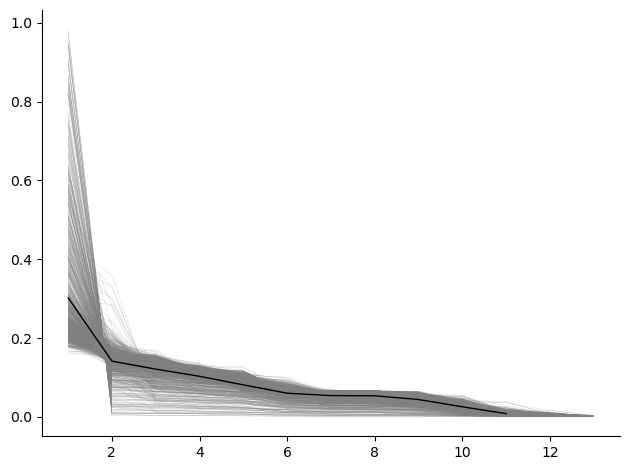

In [31]:
fig, ax = plt.subplots(1,1)
col = 'grey'
lw = 0.1
for i in range(len(sigmas)):
    ax.plot(1 + np.arange(len(sigmas[i])), sigmas[i], color=col, linewidth=lw)

ax.plot(1 + np.arange(len(mean_sigmas)), mean_sigmas, color='k', linewidth=1)

sns.despine()
plt.tight_layout()
plt.show()


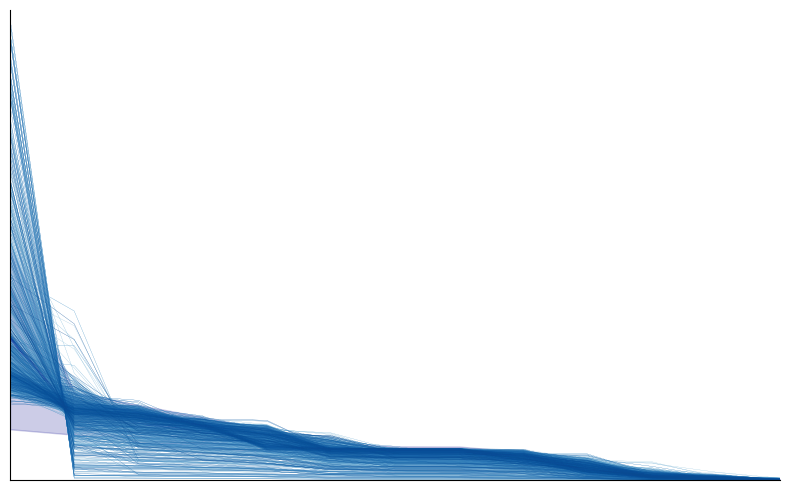

In [52]:
# Plot setup
fig, ax = plt.subplots(figsize=(8, 5))
lw = 0.1  # Line width for individual lines
ms = np.zeros((13,))
mss = []
# Plot each individual line with a color gradient
for i in range(len(sigmas)):
    color = plt.cm.Blues(0.3 + 0.6 * i / len(sigmas))  # Create gradient color
    ax.plot(1 + np.arange(len(sigmas[i])), sigmas[i], color=color, linewidth=lw)
    ms += sigmas[i]
    mss.append([sigmas[i][j] if j < len(sigmas[i]) else 0 for j in range(13)])

ms /= len(sigmas)
mss = np.array(mss)
s = 1.25 * np.std(mss,axis=0)
# Plot the mean line with a thicker line and shaded area
mean_line_color = 'darkblue'
ax.fill_between(1 + np.arange(len(ms)), ms - s, ms + s, color=mean_line_color, alpha=0.2)
ax.plot(1 + np.arange(len(mean_sigmas)), mean_sigmas, color=mean_line_color, linewidth=2, label='Mean Sigma')


# Plot each individual line with a color gradient
for i in range(len(sigmas)):
    color = plt.cm.Blues(0.3 + 0.6 * i / len(sigmas))  # Create gradient color
    ax.plot(1 + np.arange(len(sigmas[i])), sigmas[i], color=color, linewidth=lw)

# Aesthetics adjustments
# ax.set_title("Sigma Variation with Mean Trend", fontsize=14, weight='bold')
# ax.set_xlabel("Index", fontsize=12)
# ax.set_ylabel("Sigma Value", fontsize=12)
# ax.legend()

plt.ylim([0,1])
plt.xlim([1,13])
plt.xticks([])
plt.yticks([])


sns.despine()
plt.tight_layout()
fig.savefig('scree-main.png', transparent=True)
plt.show()


In [41]:
mss = np.array(mss)

In [46]:
np.std(mss,axis=0)

array([0.15533062, 0.03617776, 0.030739  , 0.02487663, 0.0212373 ,
       0.01488638, 0.0139386 , 0.01407686, 0.01223098, 0.00967061,
       0.00425738, 0.00251401, 0.00074319])

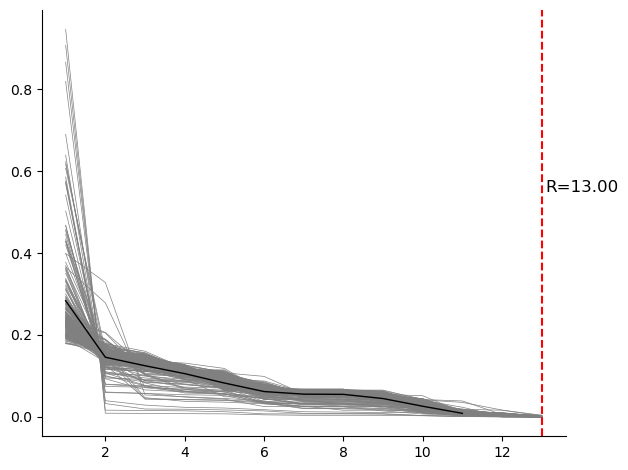

In [18]:
fig, ax = plt.subplots(1,1)
col = 'grey'
lw = 0.5
for i in range(len(sigmas)):
    ax.plot(1 + np.arange(len(sigmas[i])), sigmas[i], color=col, linewidth=lw)

ax.plot(1 + np.arange(len(mean_sigmas)), mean_sigmas, color='k', linewidth=1)

ax.axvline(x=np.mean(components), color='r', linestyle='--')

mean_x = np.mean(components)
ax.annotate(
    f'R={mean_x:.2f}',          # Text for annotation
    xy=(mean_x, 0.5),    # Position to annotate (x, y)
    xytext=(mean_x + 0.1, 0.55),  # Text position (slightly offset for visibility)
    # arrowprops=dict(facecolor='black', shrink=0.05),  # Optional arrow from text to point
    fontsize=12          # Increase text size if needed
)

sns.despine()
plt.tight_layout()
plt.show()


# Circos Plots

In [8]:
jacobian_matrix

Matrix([
[0.25*Cdc25/(Cdc25 + 0.1)**2 + 0.826446280991735*Cdc25*(G2K + 0.05*PG2)/(1 - 0.909090909090909*Cdc25)**2 - 0.25/(Cdc25 + 0.1) + (G2K + 0.05*PG2)/(1.1 - Cdc25),                               0,       0,               Cdc25/(1.1 - Cdc25),                   0,                                       0,                                               0,                   0.05*Cdc25/(1.1 - Cdc25),                   0,                                                                                                                           0,                                                                                                                               0,                                                                                                                                                             0,                                                                                                                                                     0],
[            

In [37]:
from pycirclize import Circos

In [70]:
thresh = 0.00001

## Jacobian Sparsity

# Sector = 'Cdc25'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (45.00 - 67.23)
# Track List = []

# Sector = 'G1K'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (69.23 - 91.46)
# Track List = []

# Sector = 'G1R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (93.46 - 115.69)
# Track List = []

# Sector = 'G2K'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (117.69 - 139.92)
# Track List = []



/tmp/ipykernel_1339644/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)


# Sector = 'G2R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (141.92 - 164.15)
# Track List = []

# Sector = 'IE'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (166.15 - 188.38)
# Track List = []

# Sector = 'mass'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (190.38 - 212.62)
# Track List = []

# Sector = 'PG2'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (214.62 - 236.85)
# Track List = []

# Sector = 'PG2R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (238.85 - 261.08)
# Track List = []

# Sector = 'R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (263.08 - 285.31)
# Track List = []

# Sector = 'UbE'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (287.31 - 309.54)
# Track List = []

# Sector = 'UbE2'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (311.54 - 333.77)
# Track List = []

# Sector = 'Wee1'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (335.77 - 358.00)
# Track List = []

i=0, gene1='Cdc25'
i=1, gene1='G1K'
i=2, gene1='G1R'
i=3, gene1='G2K'
i=4, gene1='G2R'
i=5, gene1='IE'
i=6, gene1='mass'
i=7, 

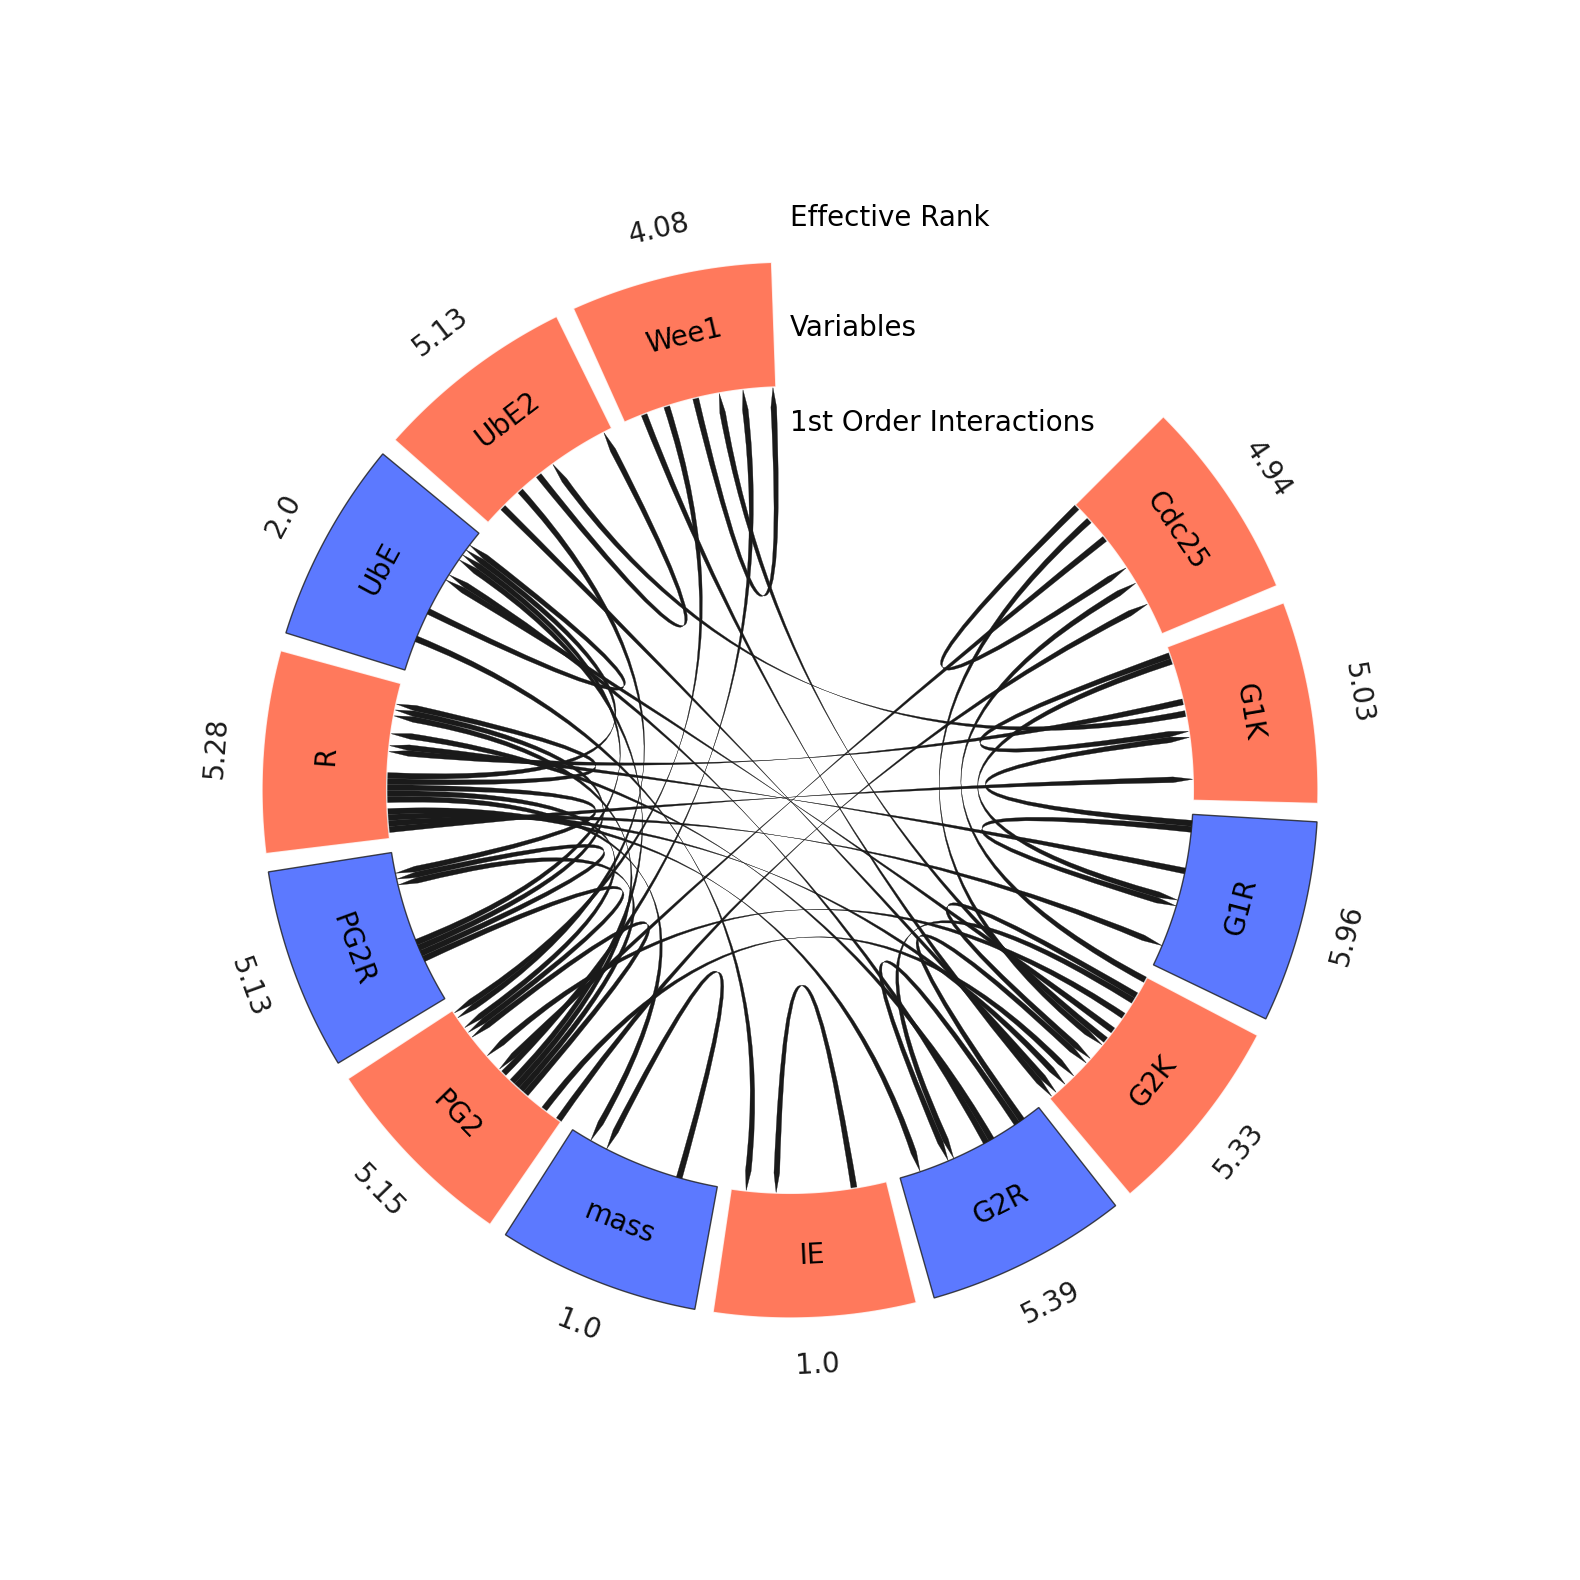

In [89]:
thresh = 0.00001
scalingFactor = 6
sectors = {}
for gene in GENES:
    sectors[gene] = (2 * len(GENES))

circos = Circos(sectors, space=2, start = 45, end=360)

vibrant_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#FFD133", "#33FFF5", "#FF8F33"]

biomarkers = ['G1R', 'G2R', 'PG2R', 'UbE', 'mass']


for i, sector in enumerate(circos.sectors):
    print(sector)
    track1 = sector.add_track((72, 55))
    name = sector.name
    if name == 'R':
        name = 'Rum1'
    ec = 'w'
    if name in biomarkers:
        ec = 'k'
#    track1.axis(fc=vibrant_colors[i % len(vibrant_colors)], alpha=0.8, ec=ec)  # High opacity for strong color
    if sector.name in biomarkers:
        track1.axis(fc=vibrant_colors[2], alpha=0.8, ec=ec)  # High opacity for strong color
    else:
        track1.axis(fc=vibrant_colors[0], alpha=0.8, ec=ec)  # High opacity for strong color
    track1.text(f"{sector.name}")
    
    # track2 = sector.add_track((85, 100))
    Omats = NOM_dict[sector.name]
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=thresh)
    mean_x = round(np.mean(components), 2)

    track1 = sector.add_track((74, 83))
    track1.axis(fc='w', alpha=0.8, ec='w')  # High opacity for strong color
    track1.text(f"{mean_x}", color='k')

'''
for i, gene1 in enumerate(biomarkers):
    for j, gene2 in enumerate(biomarkers):
        if j <= i:
            continue
        circos.link((gene1, 0, 2*len(GENES)), (gene2, 0, 2*len(GENES)))
'''

for i, gene1 in enumerate(GENES):
    print(f"{i=}, {gene1=}")
    for j, gene2 in enumerate(GENES):
        if jacobian_matrix[i,j] == 0:
            continue
        circos.link((gene1, j, j + 1), (gene2, len(GENES) + i, len(GENES) + i + 1), direction=1, color='k', alpha=1)

text_common_kw = dict(ha="left", va="center", size=10)
circos.text("1st Order Interactions", r = 50, **text_common_kw)
circos.text("Variables", r = 63, **text_common_kw)
circos.text("Effective Rank", r=78, **text_common_kw)
# circos.text("Sensor Scree Plot", r=92,  **text_common_kw)

# fig = circos.plotfig()

fig = circos.plotfig(dpi=200)
circos.savefig("cell-cycle-annotated-v6.png")
plt.show()



In [13]:
NOM_dict

{'Cdc25': [],
 'G1K': [],
 'G1R': [],
 'G2K': [],
 'G2R': [],
 'IE': [],
 'mass': [],
 'PG2': [],
 'PG2R': [],
 'R': [],
 'UbE': [],
 'UbE2': [],
 'Wee1': [],
 'all': [array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ...,

In [ ]:
sectors = {}
for gene in GENES:
    sectors[gene] = (2 * len(GENES))

circos = Circos(sectors, space=5)

vibrant_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#FFD133", "#33FFF5", "#FF8F33"]

for i, sector in enumerate(circos.sectors):
    track1 = sector.add_track((85, 100))
    track1.axis(fc=vibrant_colors[i % len(vibrant_colors)], alpha=0.8)  # High opacity for strong color
    # track1.axis(fc="tomato", alpha=0.5)
    track1.text(sector.name)

biomarkers = ['G1R', 'G2R', 'PG2R', 'UbE']
for i, gene1 in enumerate(biomarkers):
    for j, gene2 in enumerate(biomarkers):
        if j <= i:
            continue
        circos.link((gene1, j, j + 1), (gene2, len(GENES) + i, len(GENES) + i + 1), direction=1)
#for i, gene1 in enumerate(GENES):
#    print(f"{i=}, {gene1=}")
#    for j, gene2 in enumerate(GENES):
#        if jacobian_matrix[i,j] == 0:
#            continue
#        circos.link((gene1, j, j + 1), (gene2, len(GENES) + i, len(GENES) + i + 1), direction=1)

fig = circos.plotfig()
plt.show()



i=0, gene1='Cdc25'
i=1, gene1='G1K'
i=2, gene1='G1R'
i=3, gene1='G2K'
i=4, gene1='G2R'
i=5, gene1='IE'
i=6, gene1='mass'
i=7, gene1='PG2'
i=8, gene1='PG2R'
i=9, gene1='R'
i=10, gene1='UbE'
i=11, gene1='UbE2'
i=12, gene1='Wee1'


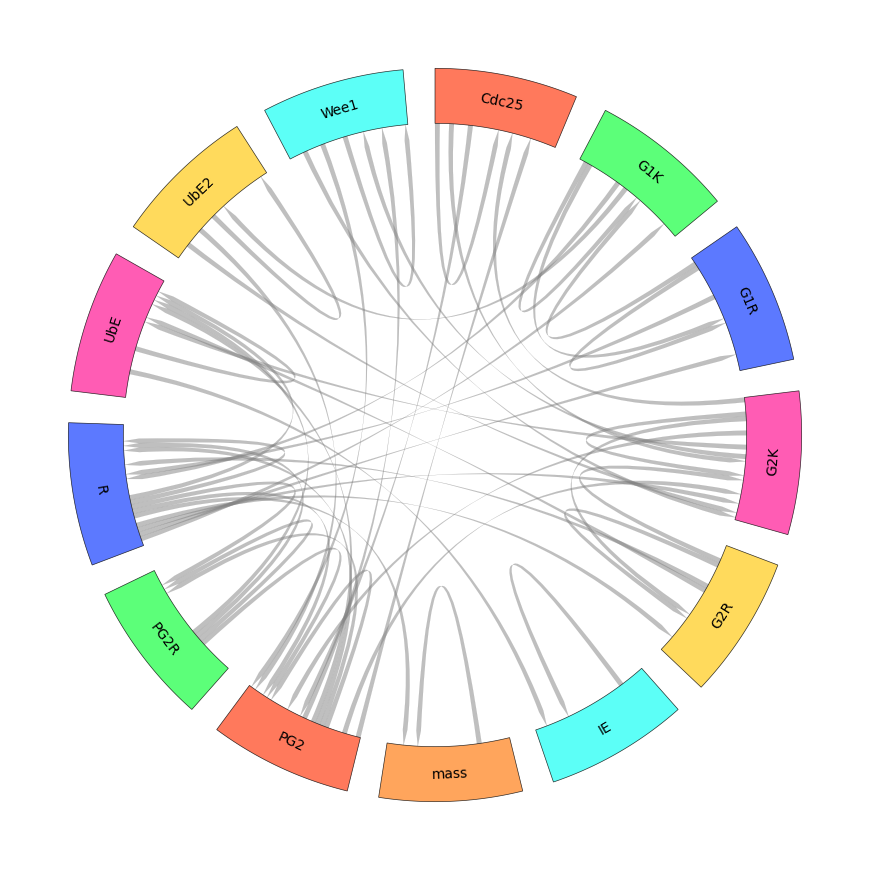

In [14]:
sectors = {}
for gene in GENES:
    sectors[gene] = (2 * len(GENES))

circos = Circos(sectors, space=5)

vibrant_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#FFD133", "#33FFF5", "#FF8F33"]

for i, sector in enumerate(circos.sectors):
    track1 = sector.add_track((85, 100))
    track1.axis(fc=vibrant_colors[i % len(vibrant_colors)], alpha=0.8)  # High opacity for strong color
    # track1.axis(fc="tomato", alpha=0.5)
    track1.text(sector.name)

for i, gene1 in enumerate(GENES):
    print(f"{i=}, {gene1=}")
    for j, gene2 in enumerate(GENES):
        if jacobian_matrix[i,j] == 0:
            continue
        circos.link((gene1, j, j + 1), (gene2, len(GENES) + i, len(GENES) + i + 1), direction=1)

# circos.savefig("circos-learn.png")
fig = circos.plotfig()
plt.show()

## Jacobian Sparsity with Scree Plots

In [15]:
thresh = 0.05
scalingFactor = 6
sectors = {}
for gene in GENES:
    sectors[gene] = (2 * len(GENES))

circos = Circos(sectors, space=2)

vibrant_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#FFD133", "#33FFF5", "#FF8F33"]

for i, sector in enumerate(circos.sectors):
    track1 = sector.add_track((72, 55))
    track1.axis(fc=vibrant_colors[i % len(vibrant_colors)], alpha=0.8)  # High opacity for strong color
    track1.text(f"{sector.name}")
    
    track2 = sector.add_track((85, 100))
    Omats = NOM_dict[sector.name]
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=thresh)
    col = 'grey'
    lw = 0.5
    for i in range(len(sigmas)):
        track2.line((scalingFactor)*np.arange(len(sigmas[i]))[:5], sigmas[i][:5], color=col, linewidth=lw)

    track2.line((scalingFactor)*np.arange(len(mean_sigmas))[:5], mean_sigmas[:5], color='k', linewidth=1)
    mean_x = np.mean(components)
    track2.line(scalingFactor * np.array([mean_x, mean_x]), [0, 1], color='r', linestyle='--')

    track1 = sector.add_track((75, 85))
    track1.axis(fc='k', alpha=0.8)  # High opacity for strong color
    track1.text(f"{mean_x}", color='w')

for i, gene1 in enumerate(GENES):
    print(f"{i=}, {gene1=}")
    for j, gene2 in enumerate(GENES):
        if jacobian_matrix[i,j] == 0:
            continue
        circos.link((gene1, j, j + 1), (gene2, len(GENES) + i, len(GENES) + i + 1), direction=1)

# circos.savefig("cell-cycle-jacobian-scree.png")
fig = circos.plotfig()
plt.show()

/tmp/ipykernel_1722786/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)


KeyboardInterrupt: 

## Annotated Circos Plot

# Sector = 'Cdc25'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (45.00 - 67.23)
# Track List = []

# Sector = 'G1K'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (69.23 - 91.46)
# Track List = []

# Sector = 'G1R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (93.46 - 115.69)
# Track List = []

# Sector = 'G2K'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (117.69 - 139.92)
# Track List = []

# Sector = 'G2R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (141.92 - 164.15)
# Track List = []

# Sector = 'IE'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (166.15 - 188.38)
# Track List = []

# Sector = 'mass'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (190.38 - 212.62)
# Track List = []



/tmp/ipykernel_1722786/2257163869.py:40: RuntimeWarning: invalid value encountered in divide
  O = O / O.sum(axis=1, keepdims=True)


# Sector = 'PG2'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (214.62 - 236.85)
# Track List = []

# Sector = 'PG2R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (238.85 - 261.08)
# Track List = []

# Sector = 'R'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (263.08 - 285.31)
# Track List = []

# Sector = 'UbE'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (287.31 - 309.54)
# Track List = []

# Sector = 'UbE2'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (311.54 - 333.77)
# Track List = []

# Sector = 'Wee1'
# Size = 26 (0 - 26)
# Degree Size = 22.23 (335.77 - 358.00)
# Track List = []

i=0, gene1='Cdc25'
i=1, gene1='G1K'
i=2, gene1='G1R'
i=3, gene1='G2K'
i=4, gene1='G2R'
i=5, gene1='IE'
i=6, gene1='mass'
i=7, gene1='PG2'
i=8, gene1='PG2R'
i=9, gene1='R'
i=10, gene1='UbE'
i=11, gene1='UbE2'
i=12, gene1='Wee1'


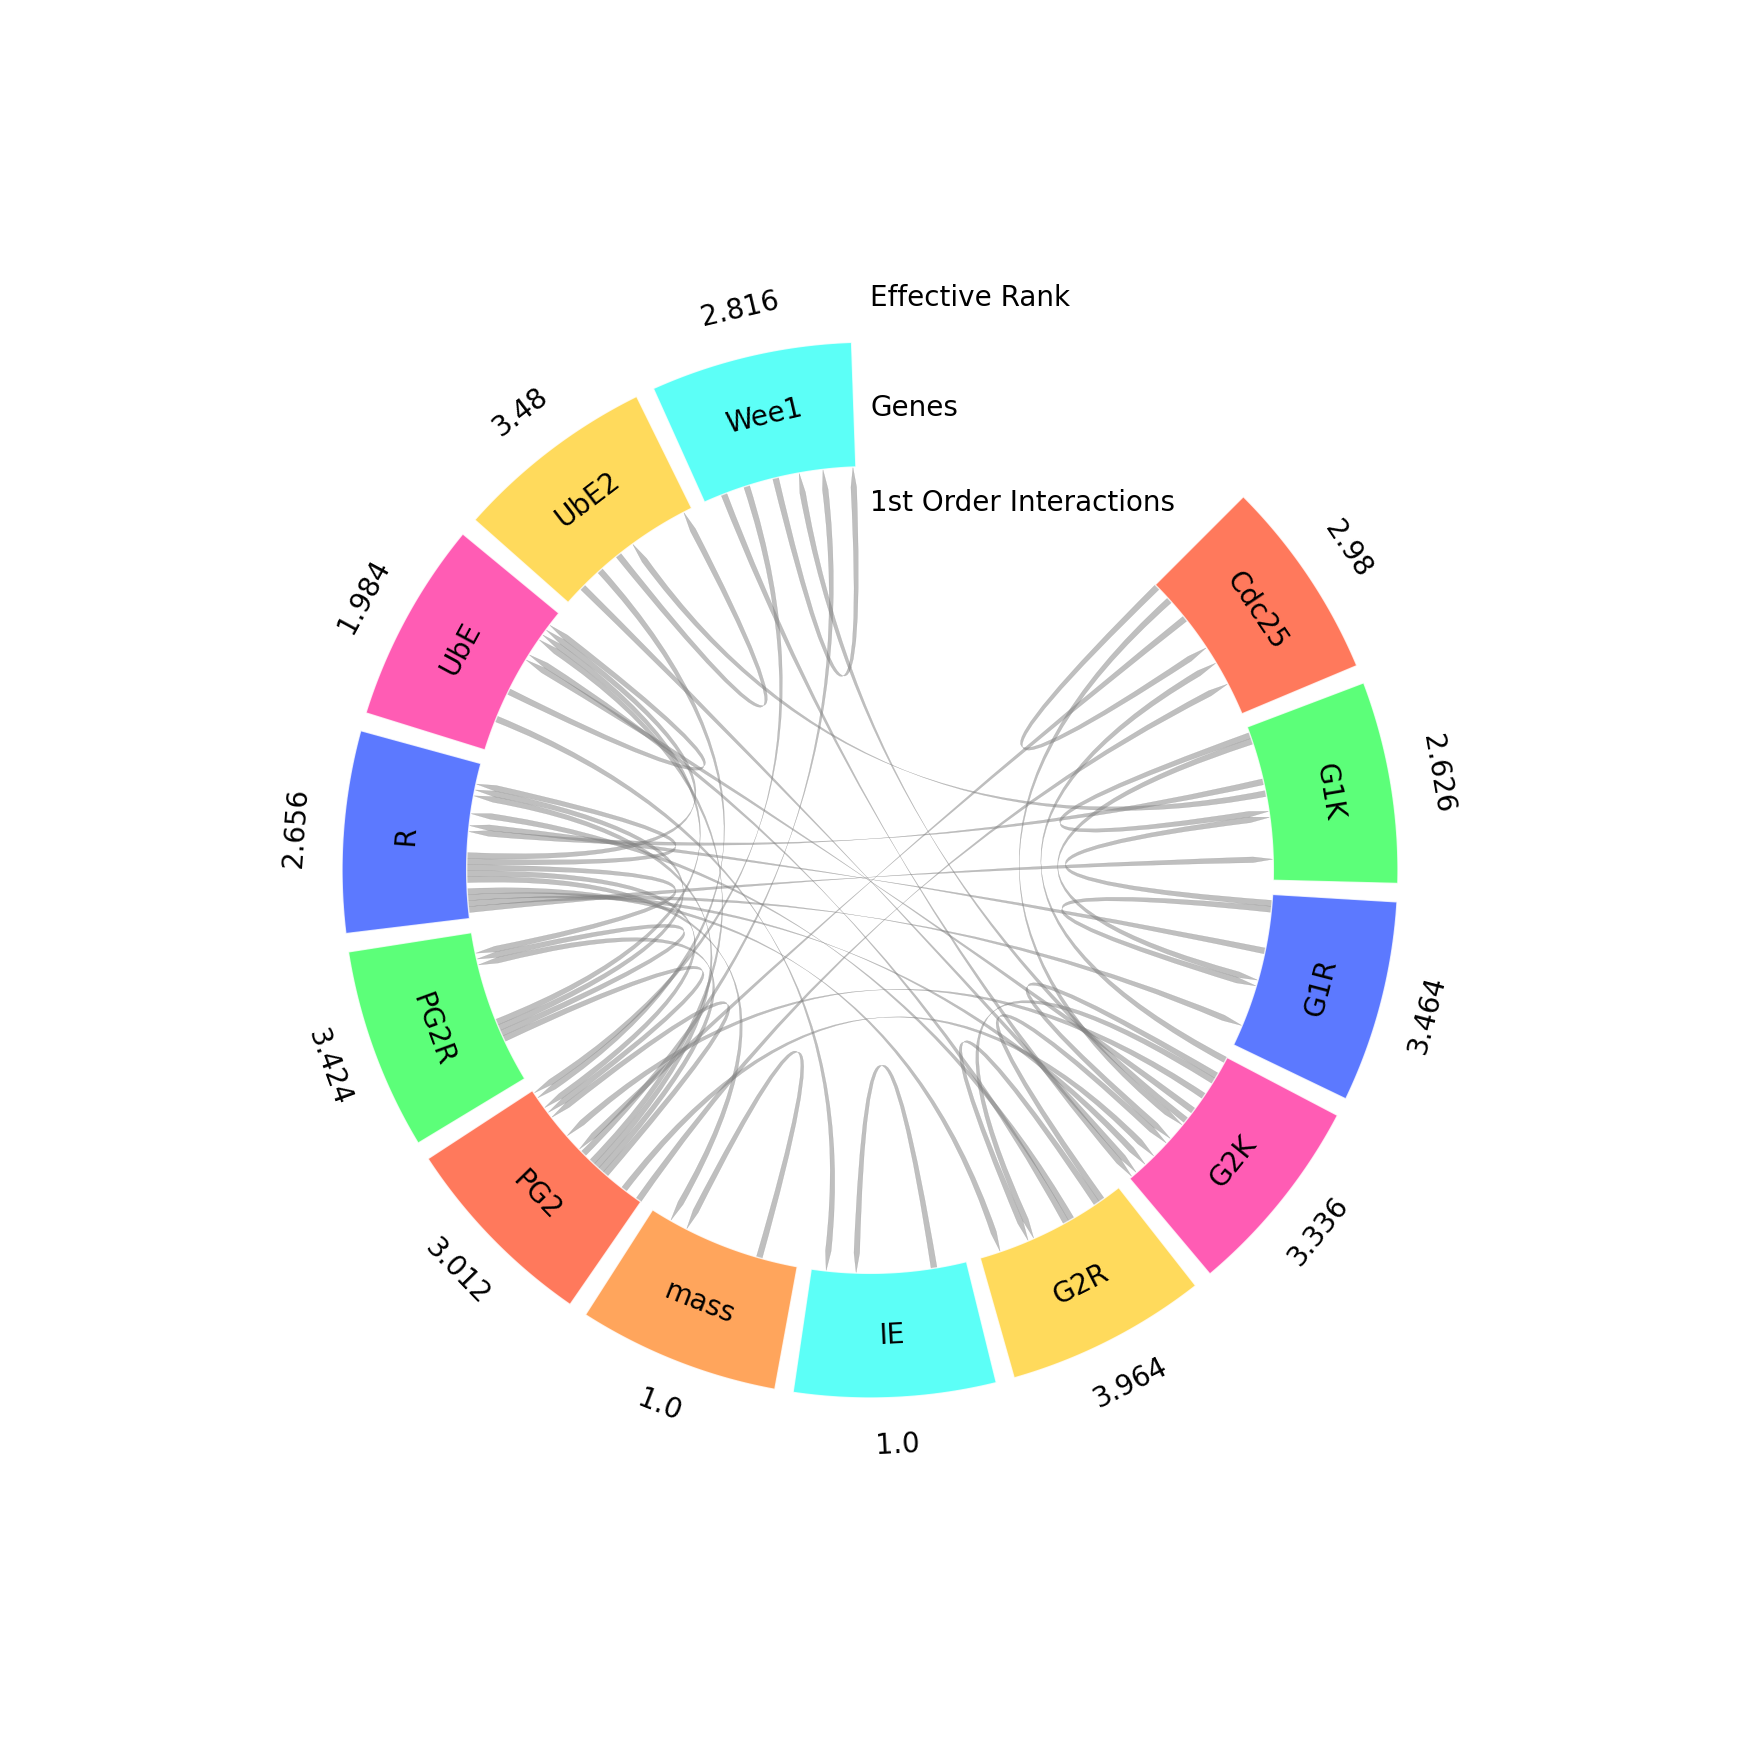

In [28]:
thresh = 0.05
scalingFactor = 6
sectors = {}
for gene in GENES:
    sectors[gene] = (2 * len(GENES))

circos = Circos(sectors, space=2, start = 45, end=360)

vibrant_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#FFD133", "#33FFF5", "#FF8F33"]

for i, sector in enumerate(circos.sectors):
    print(sector)
    track1 = sector.add_track((72, 55))
    track1.axis(fc=vibrant_colors[i % len(vibrant_colors)], alpha=0.8, ec='w')  # High opacity for strong color
    track1.text(f"{sector.name}")
    
    # track2 = sector.add_track((85, 100))
    Omats = NOM_dict[sector.name]
    sigmas, mean_sigmas, components = omatsSVD(Omats, thresh=thresh)
    # col = 'grey'
    # lw = 0.5
    # for i in range(len(sigmas)):
    #     track2.line((scalingFactor)*np.arange(len(sigmas[i]))[:5], sigmas[i][:5], color=col, linewidth=lw)

    # track2.line((scalingFactor)*np.arange(len(mean_sigmas))[:5], mean_sigmas[:5], color='k', linewidth=1)
    mean_x = np.mean(components)
    # track2.line(scalingFactor * np.array([mean_x, mean_x]), [0, 1], color='r', linestyle='--')

    track1 = sector.add_track((74, 83))
    track1.axis(fc='w', alpha=0.8, ec='w')  # High opacity for strong color
    track1.text(f"{mean_x}", color='k')

for i, gene1 in enumerate(GENES):
    print(f"{i=}, {gene1=}")
    for j, gene2 in enumerate(GENES):
        if jacobian_matrix[i,j] == 0:
            continue
        circos.link((gene1, j, j + 1), (gene2, len(GENES) + i, len(GENES) + i + 1), direction=1)

text_common_kw = dict(ha="left", va="center", size=10)
circos.text("1st Order Interactions", r = 50, **text_common_kw)
circos.text("Genes", r = 63, **text_common_kw)
circos.text("Effective Rank", r=78, **text_common_kw)
# circos.text("Sensor Scree Plot", r=92,  **text_common_kw)

# fig = circos.plotfig()

fig = circos.plotfig(dpi=200)
plt.show()

circos.savefig("cell-cycle-annotated-v3.png")

In [21]:
help(track1.axis)

Help on method axis in module pycirclize.track:

axis(**kwargs) -> 'None' method of pycirclize.track.Track instance
    Plot axis
    
    By default, simple black axis params(`fc="none", ec="black", lw=0.5`) are set.
    
    Parameters
    ----------
    **kwargs : dict, optional
        Patch properties (e.g. `fc="tomato", ec="blue", hatch="//"`)
        <https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html>



# Scratch

In [60]:
matrix_df = pd.DataFrame(matrix_data, index=GENES, columns=GENES)

# Initialize Circos from matrix for plotting Chord Diagram
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=5,
    cmap="tab10",
    label_kws=dict(size=12),
    link_kws=dict(ec="black", lw=0.5, direction=1),
)

circos.savefig("circos.png")

In [32]:
from pycirclize import Circos
import numpy as np
np.random.seed(0)

# Initialize Circos sectors
sectors = {}
for gene in GENES:
    sectors[gene] = 1
circos = Circos(sectors, space=5)

# Style each sector with unique colors and add labels
sector_colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99", "#CCCCFF"]
for i, (gene, sector) in enumerate(circos.sectors.items()):
    sector.color = sector_colors[i % len(sector_colors)]  # Cycle through colors
    sector.text = gene  # Add gene name as label
    sector.text_kwargs.update({"fontsize": 12, "weight": "bold", "color": "black"})

# Define links between adjacent genes with enhanced styling
for i in range(len(GENES) - 1):
    start = (GENES[i], 0, 0)
    end = (GENES[i + 1], 0, 0)
    circos.link(start, end, lw=3, color="skyblue", alpha=0.7)  # Thicker, semi-transparent links


# circos.savefig("example01.png")
circos.savefig("circos.png")
plt.show()


AttributeError: 'list' object has no attribute 'items'

In [39]:
circos.sectors[0].color

AttributeError: 'Sector' object has no attribute 'color'

In [25]:
from pycirclize import Circos
import numpy as np
np.random.seed(0)

# Initialize Circos sectors
sectors = {"A": 10, "B": 15, "C": 12, "D": 20, "E": 15}
circos = Circos(sectors, space=5)

for sector in circos.sectors:
    # Plot sector name
    sector.text(f"Sector: {sector.name}", r=110, size=15)
    # Create x positions & random y values
    x = np.arange(sector.start, sector.end) + 0.5
    y = np.random.randint(0, 100, len(x))
    # Plot lines
    track1 = sector.add_track((80, 100), r_pad_ratio=0.1)
    track1.xticks_by_interval(interval=1)
    track1.axis()
    track1.line(x, y)
    # Plot points 
    track2 = sector.add_track((55, 75), r_pad_ratio=0.1)
    track2.axis()
    track2.scatter(x, y)
    # Plot bars
    track3 = sector.add_track((30, 50), r_pad_ratio=0.1)
    track3.axis()
    track3.bar(x, y)

# Plot links 
circos.link(("A", 0, 3), ("B", 15, 12))
circos.link(("B", 0, 3), ("C", 7, 11), color="skyblue")
circos.link(("C", 2, 5), ("E", 15, 12), color="chocolate", direction=1)
circos.link(("D", 3, 5), ("D", 18, 15), color="lime", ec="black", lw=0.5, hatch="//", direction=2)
circos.link(("D", 8, 10), ("E", 2, 8), color="violet", ec="red", lw=1.0, ls="dashed")

# circos.savefig("example01.png")
plt.show()



KeyboardInterrupt



In [41]:
from pycirclize import Circos

import pandas as pd

# Create matrix dataframe (3 x 6)
row_names = ["T1", "T2", "T3"]
col_names = ["T1", "T2", "T3", "T4", "T5", "T6"]
matrix_data = [
    [10, 16, 7, 7, 10, 8],
    [4, 9, 10, 12, 12, 7],
    [17, 13, 7, 4, 20, 4],
]
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

In [42]:
matrix_df

,T1,T2,T3,T4,T5,T6
T1,10,16,7,7,10,8
T2,4,9,10,12,12,7
T3,17,13,7,4,20,4


In [43]:
# Initialize Circos from matrix for plotting Chord Diagram
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=5,
    cmap="tab10",
    label_kws=dict(size=12),
    link_kws=dict(ec="black", lw=0.5, direction=1),
)

circos.savefig("example04.png")